In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

from datetime import datetime

# Tony Stoecker's EPG implementation in C++ (wrapped using Cython) 
import pyepg

# Daniel Brenner's EPG implementation in pure Python
from EpyG import EpyG as epg
from EpyG import Operators as operators
from EpyG.Applications import GRE_step


## Basic usage

In [2]:
M0 = 1.0
T1 = 800.0
T2 = 50.0
alpha = 40.0
phi = 0.0
TR  = 5.0
ph_inc = 50.

# Create EPG object
EPG = pyepg.PyEPG(M0, T1, T2)

# Output tissue parameters
print("Tissue parameters")
print("=================")
print("M0/T1/T2: %.2f/%.2f/%.2f\n\n" % (EPG.GetM0(), EPG.GetT1(), EPG.GetT2()))

print("Simple example")
print("==============")

# Apply RF pulse (flipangle dAlpha, phase dPhi) and evolve one repetition time TR
EPG.Step(alpha, phi, TR)
steps = EPG.GetStep()
print("Step (# of applied RF pulses): %d" % steps)
print("|Mxy|: %.2f"%EPG.GetMagA(0))
print("Mx: %.2f"%EPG.GetReA(0))
print("My: %.2f"%EPG.GetImA(0))
print("Mz: %.2f\n" % EPG.GetMagA(0,False))

# Apply RF pulse again
EPG.Step(alpha, phi, TR)
steps = EPG.GetStep()
print("Step (# of applied RF pulses): %d" % steps)
print("Mx: %.2f"%EPG.GetMagA(0))
print("Mz: %.2f\n" % EPG.GetMagA(0,False))

# Spoil transverse magnetization
EPG.NullTransverse()
print("Mx: %.2f"%EPG.GetMagA(0))
print("Mz: %.2f\n" % EPG.GetMagA(0,False))

# Back to equilibrium
EPG.Equilibrium()


steps = EPG.StepsToSS(alpha, ph_inc, TR)
print("Steps to steady state: %d"%steps)

Tissue parameters
M0/T1/T2: 1.00/800.00/50.00


Simple example
Step (# of applied RF pulses): 1
|Mxy|: 0.64
Mx: -0.00
My: 0.64
Mz: 0.77

Step (# of applied RF pulses): 2
Mx: 0.49
Mz: 0.59

Mx: 0.00
Mz: 0.59

Steps to steady state: 61


### Gradient echo (using Cython implementation of Stoecker's EPG)

In [3]:
start_time = datetime.now()
Np = 500

for j in range(100):
    with pyepg.PyEPG() as EPG:
        EPG = pyepg.PyEPG()
        EPG.SetParameters(1.0, T1, T2)
        EPG.Equilibrium()
        SigS = np.zeros(Np)
        phi_arr = np.zeros(Np)
        flip = np.ones(Np) * alpha
        SigS = EPG.GetMagTrain(flip, phi_arr, TR)
        
end_time = datetime.now()
delta = end_time - start_time
print("->Stoecker's EPG calculation was DONE in %.2f milliseconds" % (delta.total_seconds() * 1000))

->Stoecker's EPG calculation was DONE in 81.46 milliseconds


### Gradient echo (using Brenner's pure Python EPG implementation)

In [4]:
start_time = datetime.now()
T = operators.Transform(alpha=np.deg2rad(alpha), phi=phi, name="Excitation")
O = operators.Observer(f_states=(0,), z_states=(0,), name="ADC")
S = operators.Shift(shifts=1, autogrow=True, name="Dephase")
E = operators.Epsilon(TR_over_T1=TR/T1, TR_over_T2=TR/T2, name="Relaxation")
c = operators.CompositeOperator(E,S,O,T,name="GRE")

# FLASH 
for j in range(100):
    gre_graph = epg.EpyG(initial_size=256, m0=1.0)
    O.clear()
    for i in range(Np):
        c*gre_graph

    SigB = np.abs(O.get_f(0))

end_time = datetime.now()
delta = end_time - start_time
print("->Brenner's EPG calculation was DONE in %.2f milliseconds" % (delta.total_seconds() * 1000))

->Brenner's EPG calculation was DONE in 629.47 milliseconds


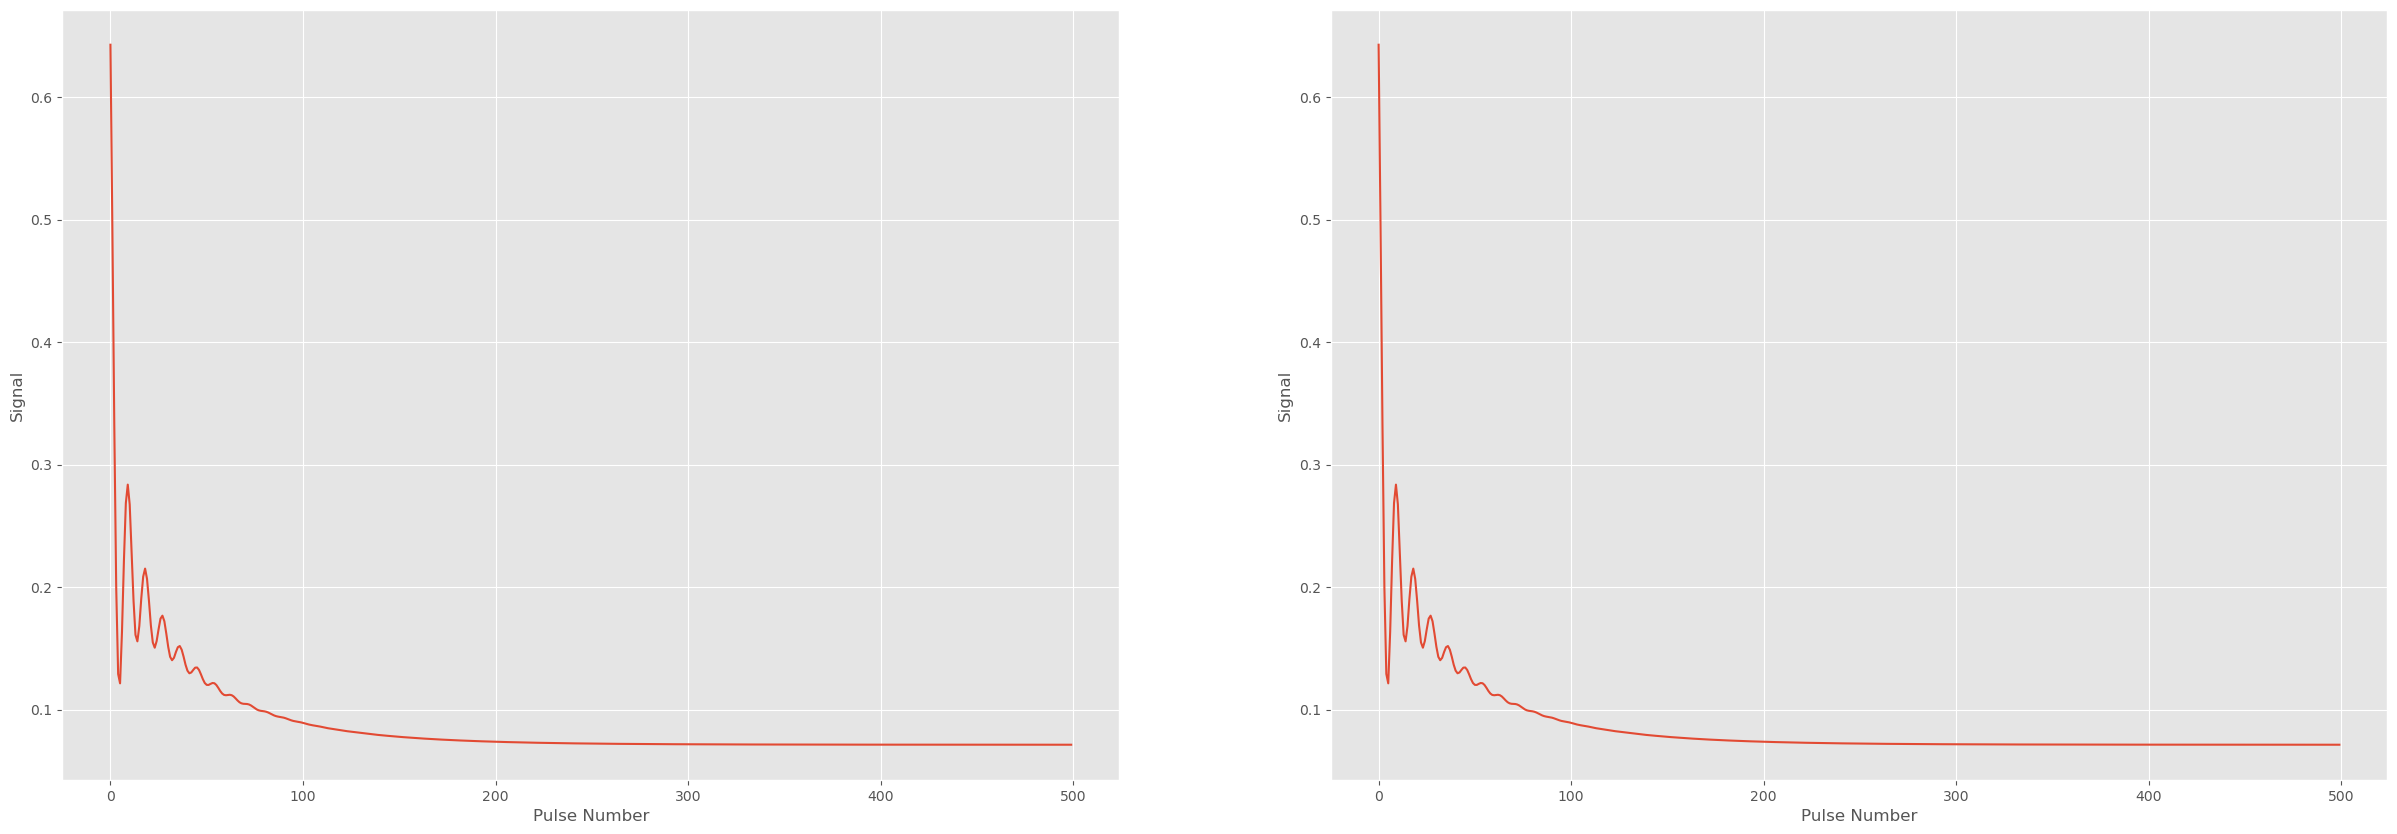

In [5]:
fig, axs = plt.subplots(1,2, figsize=(30, 10)) #W/H
axs[0].plot(SigS)
axs[0].set_xlabel("Pulse Number")
axs[0].set_ylabel("Signal")
axs[1].plot(SigB)
axs[1].set_xlabel("Pulse Number")
axs[1].set_ylabel("Signal")
plt.show()

### Signal Shaping (Gradient echo)

In [6]:
from datetime import datetime
start_time = datetime.now()
Np = 256
Ftarget = np.ones(Np)
EPG.Equilibrium()
FA_arr = EPG.FindFlipAngleTrain(Ftarget, 5.)

end_time = datetime.now()
delta = end_time - start_time
# Call ./epg in build directory for comparison (runs "main.cpp")
# average result takes 13 milliseconds (Macbook Pro i7)
print("->DONE in %.2f milliseconds" % (delta.total_seconds() * 1000))


->DONE in 6.96 milliseconds


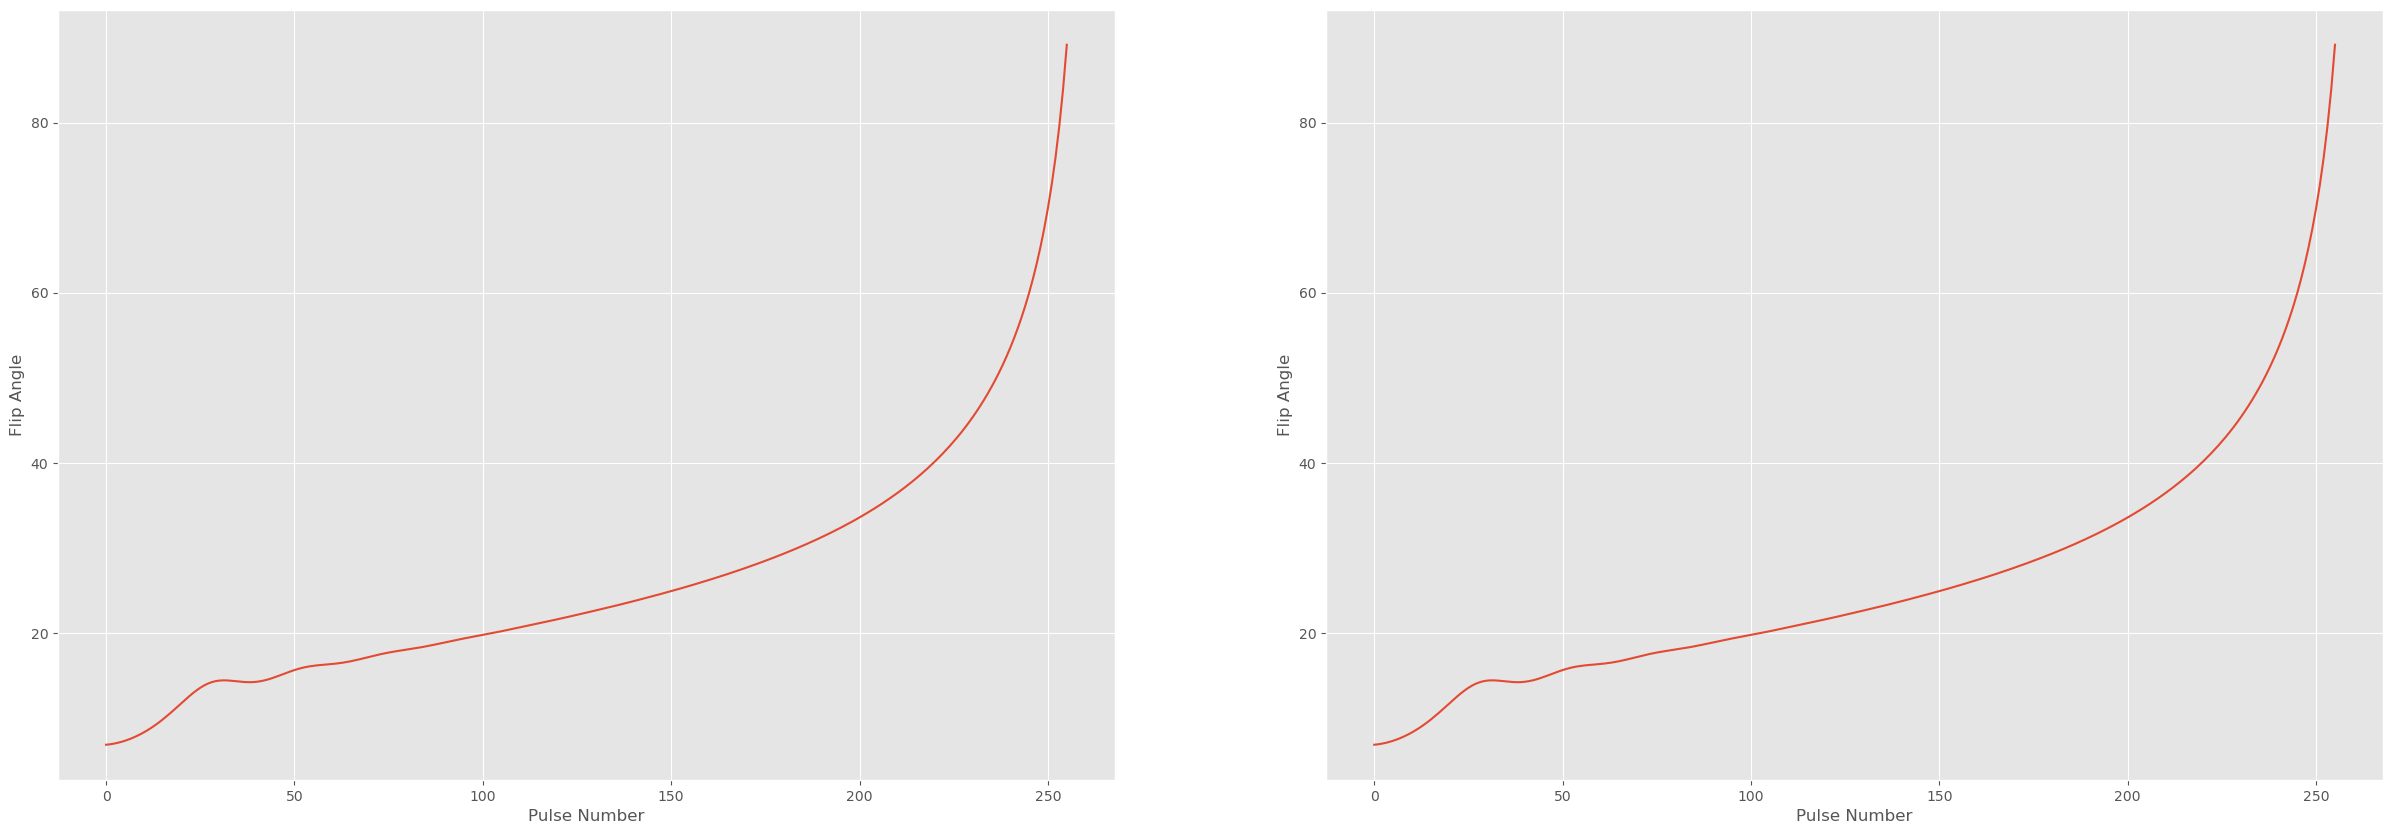

In [8]:
# Run ./epg in build directory to create gre.npy
FA_cpp = np.load('/tmp/gre.npy')

fig, axs = plt.subplots(1,2, figsize=(30, 10)) #W/H
axs[0].plot(FA_arr)
axs[0].set_xlabel("Pulse Number")
axs[0].set_ylabel("Flip Angle")
axs[1].plot(FA_cpp)
axs[1].set_xlabel("Pulse Number")
axs[1].set_ylabel("Flip Angle")
plt.show()

### GRE steady state signal with partial spoiling (as needed for phase-based T1/T2 mapping)

Function definitions with pyepg and EPyG

In [3]:
def gre_spoiled_epg(T1, T2, alpha, delta_phi, TR, abs_err_tol = 1e-6 ):
    EPG = pyepg.PyEPG()
    EPG.SetParameters(1.0, T1, T2)
    EPG.Equilibrium()
    N = EPG.StepsToSS(alpha, delta_phi, TR, abs_err_tol)
    #print('N=%d, phase=%7.5f, M=(%7.5f, %7.5f)' % (N,EPG.GetPhase(),EPG.GetReA(),EPG.GetImA() ))
    signal = (EPG.GetReA()+1.0j*EPG.GetImA())*np.exp(-1.0j*np.deg2rad(EPG.GetPhase()))
    return ( np.abs(signal), np.angle(signal) -np.pi/2 )     

def gre_spoiled_EPyG(T1, T2, alpha, delta_phi, TR, EPG_SIZE = 4096 ):
    E = operators.Epsilon(TR_over_T1=TR/T1, TR_over_T2=TR/T2)
    S = operators.Shift(shifts=1, autogrow=True, name="Dephase")
    T_phi = operators.PhaseIncrementedTransform(alpha=np.deg2rad(alpha), phi=0.0, linear_phase_inc=np.deg2rad(delta_phi), name="Excite")
    O_phi = operators.Observer(f_states=(0,), z_states=())
    ph_graph = epg.EpyG(initial_size=EPG_SIZE, m0=1.0)

    ABS_ERR_TOL = 1e-6
    last_F0 = 0.0
    j_max = -1
    for j in range(EPG_SIZE):
        T_phi*ph_graph
        phase=T_phi._phi
        O_phi*ph_graph
        F0 = O_phi.get_f(0)[j]
        if ( (np.abs(F0-last_F0) < ABS_ERR_TOL) ): # steady state condition 
            j_max=j
            break
        last_F0 = F0
        S*ph_graph
        E*ph_graph

    if (j_max<0):
        print('EPG warning: steady state not reached in ',EPG_SIZE,' steps. (T2= %5.2f / DPhi= %5.2f)' % (T2,delta_phi)) 

    #print('N=%d, phase=%5.2f, M=(%7.5f, %7.5f)' % (EPG_SIZE,np.rad2deg(phase),np.real(F0),np.imag(F0) ))
    signal = F0*np.exp(-1.0j*phase)

    return ( np.abs(signal), np.angle(signal)-np.pi/2 )     


Example with useful values.

To get the same accuracy, the error tolerance to reach the steady state is higher for stoecker-pyepg (1e-8) than for brenner-EPyG (1e-6). 

I have not checked why this is the case. Still, the cpp code is about 100 times faster than the python implementation.

d_phi = 20 | (Mag,Phase) = (0.03859, 7.83414)
->Brenner EPG calculation was DONE in 27338.16 milliseconds

d_phi = 20 | (Mag,Phase) = (0.03859, 7.83458)
->Stoecker EPG calculation was DONE in 129.07 milliseconds



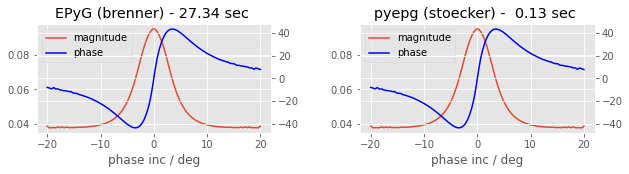

In [4]:
T1        = 1000
T2        = 80
TR        = 8
alpha     = 20
N         = 100
d_phi     = np.linspace(-20,20,N)
Adb       = np.zeros(N)
Pdb       = np.zeros(N)
Ats       = np.zeros(N)
Pts       = np.zeros(N)

start_time = datetime.now()
for i in range(N):
    Adb[i],Pdb[i] = gre_spoiled_EPyG(T1, T2, alpha, d_phi[i], TR)
deltaB = datetime.now() - start_time
print('d_phi = %d | (Mag,Phase) = (%7.5f, %7.5f)' % (d_phi[N-1],Adb[N-1],np.rad2deg(Pdb[N-1])))
print('->Brenner EPG calculation was DONE in %.2f milliseconds\n' % (deltaB.total_seconds() * 1000))

start_time = datetime.now()
for i in range(N):
    Ats[i],Pts[i] = gre_spoiled_epg(T1, T2, alpha, d_phi[i], TR, 1e-10)
deltaS = datetime.now() - start_time
print('d_phi = %d | (Mag,Phase) = (%7.5f, %7.5f)' % (d_phi[N-1],Ats[N-1],np.rad2deg(Pts[N-1])))
print('->Stoecker EPG calculation was DONE in %.2f milliseconds\n' % (deltaS.total_seconds() * 1000))

fig, ax = plt.subplots(1,3,figsize=(10,2),gridspec_kw={'width_ratios': [1, .1, 1]})
ax[0].plot(d_phi,Adb,label='magnitude')
ax[0].plot([],[],'b',label='phase' )
ax0 = ax[0].twinx()
ax0.plot(d_phi,np.rad2deg(Pdb),'b')
ax[0].set_title('EPyG (brenner) - %5.2f sec ' % (deltaB.total_seconds()))
ax[0].set_xlabel('phase inc / deg')
ax[0].legend(loc='upper left')
ax[1].set_axis_off()
ax[2].plot(d_phi,Ats,label='magnitude')
ax[2].plot([],[],'b',label='phase' )
ax2 = ax[2].twinx()
ax2.plot(d_phi,np.rad2deg(Pts),'b',label='phase')
ax[2].set_title('pyepg (stoecker) - %5.2f sec ' % (deltaS.total_seconds()))
ax[2].set_xlabel('phase inc / deg')
ax[2].legend(loc='upper left')
plt.show()
